In [11]:
import numpy as np
import matplotlib.pyplot as plt
import boost_histogram as bh
import tensorflow as tf
import sklearn as sk
import pandas as pd
import pyarrow.feather as feather
import sklearn.model_selection as model_selection
import os
import joblib
from tensorflow.keras import backend as K

class DataLoader:
    def __init__(self, sm_file_name, smeft_file_name, selected_labels, n_sm_events, n_smeft_events):
        self.sm_file_name = sm_file_name
        self.smeft_file_name = smeft_file_name
        self.selected_labels = selected_labels
        self.n_sm_events = n_sm_events
        self.n_smeft_events = n_smeft_events
        self.smeft_x_train, self.smeft_y_train, self.smeft_train_weights, self.smeft_x_validate, self.smeft_y_validate, self.smeft_validate_weights, self.smeft_x_test, self.smeft_y_test, self.smeft_weights_test, self.sm_x_data, self.sm_y_data, self.sm_weights = self.data_preprocessing()

    def data_preprocessing(self):
        sm_df = self.import_feather(self.sm_file_name, self.n_sm_events)
        smeft_df = self.import_feather(self.smeft_file_name, self.n_smeft_events)
        smeft_df, sm_df = self.dimensionality_reduction(smeft_df, sm_df)
        smeft_df = self.parity_transform(smeft_df, True)
        sm_df = self.parity_transform(sm_df, False)

        smeft_x_data, smeft_y_data, smeft_weights = self.df_to_numpy(smeft_df, 0)
        sm_x_data, sm_y_data, sm_weights = self.df_to_numpy(sm_df, 2)
        
        smeft_x_train, smeft_x_test, smeft_y_train, smeft_y_test, smeft_train_weights, smeft_weights_test = sk.model_selection.train_test_split(smeft_x_data, smeft_y_data, smeft_weights, test_size=0.2, random_state=42, stratify=smeft_y_data)
        smeft_x_validate, smeft_x_test, smeft_y_validate, smeft_y_test, smeft_validate_weights, smeft_weights_test = sk.model_selection.train_test_split(smeft_x_test, smeft_y_test, smeft_weights_test, test_size=0.5, random_state=42, stratify=smeft_y_test)

        return smeft_x_train, smeft_y_train, smeft_train_weights, smeft_x_validate, smeft_y_validate, smeft_validate_weights, smeft_x_test, smeft_y_test, smeft_weights_test, sm_x_data, sm_y_data, sm_weights

    def import_feather(self, file_name, n_events):
        df = feather.read_feather(file_name)
        df['Event.Weight'] = df['Event.Weight'] * 139 / n_events

        df = df.set_index(['entry', 'subentry'])
        feature_columns = df.columns.intersection(self.selected_labels).tolist()

        event_weights = df["Event.Weight"].groupby("entry").first()
        df = (df.assign(counter=df.groupby('entry').cumcount())
                .pivot_table(index='entry', columns=['subentry'], values=feature_columns, dropna=False, fill_value=0))

        df["Event.Weight"] = event_weights

        return df
        
    def dimensionality_reduction(self, smeft_df, sm_df):
        smeft_columns = smeft_df.columns.tolist()
        sm_columns = sm_df.columns.tolist()
        print("smeft columns",smeft_columns)
        print("sm columns",sm_columns)

        excess_columns = len(smeft_columns) - len(sm_columns)

        if excess_columns > 0:
            smeft_df = smeft_df[sm_columns]
        if excess_columns < 0:
            sm_df = sm_df[smeft_columns]
        else:
            pass
        
        return smeft_df, sm_df

    def df_to_numpy(self, df, class_label):
        weight_data = df['Event.Weight'].to_numpy().reshape(-1, 1)
        df = df.drop(columns=['Event.Weight'])
        x_data = df.to_numpy()
        if class_label == 0:
            y_data = (weight_data > 0).astype(int)
        else:
            y_data = np.full_like(weight_data, class_label)

        return x_data, y_data, weight_data

    @staticmethod
    def parity_transform(selected_df, is_smeft):
        Pflipped_df = selected_df.copy()
        eta_columns = Pflipped_df.filter(like="Eta").columns
        phi_columns = Pflipped_df.filter(like="Phi").columns
        Pflipped_df.loc[:, eta_columns] *= -1
        Pflipped_df.loc[:, phi_columns] += np.pi

        Pflipped_df.loc[:, phi_columns] = (Pflipped_df.loc[:, phi_columns] - 2 * np.pi * (Pflipped_df[phi_columns] > np.pi)).astype(np.float32)
        Pflipped_df.loc[:, phi_columns] = (Pflipped_df.loc[:, phi_columns] + 2 * np.pi * (Pflipped_df[phi_columns] < -np.pi)).astype(np.float32)
        if is_smeft:
            Pflipped_df["Event.Weight"] *= -1

        total_df = pd.concat([selected_df, Pflipped_df], axis=0, ignore_index=True)
        total_df["Event.Weight"] *= 0.5

        return total_df
    
class CustomKerasClassifier(sk.base.BaseEstimator, sk.base.ClassifierMixin):
    def __init__(self, input_shape, learning_rate=0.001, neurons=16, layers=2, reg_strength=0.001, epochs=50, patience=2, dropout_rate=0, batch_size=256):
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.neurons = neurons
        self.layers = layers
        self.reg_strength = reg_strength
        self.epochs = epochs
        self.patience = patience
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.model = None

    def build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.Input(shape=(self.input_shape,)))

        for _ in range(self.layers-1):
            model.add(tf.keras.layers.Dense(self.neurons, activation='relu'))

        model.add(tf.keras.layers.Dense(self.neurons, kernel_regularizer=tf.keras.regularizers.l2(self.reg_strength)))
        model.add(tf.keras.layers.Dropout(rate=self.dropout_rate))
        model.add(tf.keras.layers.Dense(2, activation='softmax'))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, x_train, y_train, validation_data=(None, None)):
        K.clear_session()
        self.model = self.build_model()
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=self.patience, restore_best_weights=True
        )

        history = self.model.fit(
            x_train, y_train, 
            validation_data=validation_data,  
            epochs=self.epochs, 
            batch_size=self.batch_size,
            verbose=0, 
            callbacks=[early_stopping]
        )

        self.history_ = history.history

        return self

    def predict(self, x):
        return self.model.predict(x)

    def score(self, x, y):
        _, accuracy = self.model.evaluate(x, y, verbose=0)
        return accuracy

class MLModel:
    def __init__(self, scaler, all_data):
        self.model = None
        self.scaler = scaler
        self.smeft_y_train = all_data.smeft_y_train  
        self.smeft_y_validate = all_data.smeft_y_validate
        self.smeft_x_train, self.smeft_x_validate = self.data_normalisation(all_data.smeft_x_train, all_data.smeft_x_validate)

    def data_normalisation(self, x_train, x_validate):
        self.scaler.fit(x_train)
        x_train = self.scaler.transform(x_train)
        x_validate = self.scaler.transform(x_validate)

        return x_train, x_validate
    
    def grid_search(self, param_grid, model_filename):
        input_shape = self.smeft_x_train.shape[1]

        CustomKerasClassifier.total_fits = np.prod([len(v) for v in param_grid.values()]) * 2

        model = CustomKerasClassifier(input_shape=input_shape)
        grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=2, verbose=2)
        grid_result = grid.fit(self.smeft_x_train, self.smeft_y_train, validation_data=(self.smeft_x_validate, self.smeft_y_validate))

        print("Best Accuracy: {:.4f} using {}".format(grid_result.best_score_, grid_result.best_params_))
        self.model = grid_result.best_estimator_.model
        self.model.save(model_filename)
        meta_data = {
            "history": self.model.history.history,
            "scaler": self.scaler,
            "accuracy": grid_result.best_score_,
            "best_params": grid_result.best_params_
        }

        joblib.dump(meta_data, model_filename.replace(".keras", "_meta_data.joblib"))
    
    def predict(self, x_data, y_data):
        x_data = self.scaler.transform(x_data)
        y_prediction_prob = self.model.predict(x_data)
        y_prediction = np.argmax(y_prediction_prob, axis=1)
        confusion_matrix = tf.math.confusion_matrix(y_data, y_prediction).numpy()
        print("Confusion Matrix:\n", confusion_matrix)
        correct_predictions = np.trace(confusion_matrix)
        total_samples = np.sum(confusion_matrix)     
        accuracy = correct_predictions / total_samples
        print(f"Accuracy: {accuracy * 100:.2f}%")

        return y_prediction_prob

    @staticmethod
    def load_ml_model(model_filename, scaler, all_data):
        ml_model = MLModel(scaler, all_data)
        ml_model.model = tf.keras.models.load_model(model_filename)
        meta_data = joblib.load(model_filename.replace(".keras", "_meta_data.joblib"))

        history = meta_data["history"]
        best_params = meta_data["best_params"]
        accuracy = meta_data["accuracy"]
        print("Model Accuracy: {:.4f} using best hyperparameters {}".format(accuracy, best_params))

        return ml_model, history
    
class Plotter:
    @staticmethod
    def plot_loss(history, region, model_filename):
        output_filename = model_filename.replace(".keras", ".png")
        training_loss = history['loss'] 
        validation_loss = history['val_loss']
        epochs = np.arange(1, len(training_loss) + 1)
        
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, training_loss, marker='x', linestyle='-', color='mediumblue', label='Training')
        plt.plot(epochs, validation_loss, marker='x', linestyle='-', color='red', label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss $O_{{NN}}$ for ${region}$ region', fontsize=14)
        plt.legend()
        plt.savefig(f"O_NN_loss_{output_filename}", dpi=1000, bbox_inches="tight")
        plt.show()
 
    @staticmethod
    def plot_accuracy(history, region, model_filename):
        output_filename = model_filename.replace(".keras", ".png")
        training_accuracy = history['accuracy'] 
        validation_accuracy = history['val_accuracy']
        epochs = np.arange(1, len(training_accuracy) + 1)

        plt.figure(figsize=(8, 5))
        plt.plot(epochs, training_accuracy, marker='x', linestyle='-', color='mediumblue', label='Training')
        plt.plot(epochs, validation_accuracy, marker='x', linestyle='-', color='red', label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy $O_{{NN}}$ for ${region}$ region', fontsize=14)
        plt.legend()
        plt.savefig(f"O_NN_accuracy_{output_filename}", dpi=1000, bbox_inches="tight")
        plt.show()

    @staticmethod
    def chi_squared(observed, expected, uncertainty):
        chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)
        return chi_squared

    @staticmethod        
    def plot_ml_observable(ml_results, weight_data, region, model_filename):
        output_filename = model_filename.replace(".keras", ".png")
        scale_factor = 1

        ml_observable = Plotter.find_ml_observable(ml_results)

        bin_number = 20
        range_limit = (-1, 1)

        histogram_0 = bh.Histogram(bh.axis.Regular(bin_number, *range_limit, underflow=False, overflow=False))
        print("ml and Weight shape", ml_observable.shape, weight_data.shape)
        histogram_0.fill(ml_observable, weight=weight_data)

        bin_widths = histogram_0.axes[0].widths
        differential_cross_section_0 = histogram_0.view() / bin_widths

        hist_0_squared = bh.Histogram(histogram_0.axes[0])
        hist_0_squared.fill(ml_observable, weight=weight_data**2)

        uncertainty_0 = np.sqrt(hist_0_squared.view()) / bin_widths

        bin_centers = histogram_0.axes[0].centers
        bin_edges = histogram_0.axes[0].edges

        chi_squared_1 = Plotter.chi_squared(differential_cross_section_0, 0, uncertainty_0)
        print("chi_squared_1 about y=0:", chi_squared_1)

        plt.figure()

        plt.hist(bin_edges[:-1], bins=bin_edges, weights=differential_cross_section_0 /scale_factor, label=r"$O_{NN}$", color='mediumblue', histtype='step')
        plt.errorbar(bin_centers, differential_cross_section_0 / scale_factor, yerr=uncertainty_0 /scale_factor, fmt='None', color='mediumblue')

        plt.title(f'$O_{{NN}}$ for ${region}$ region', fontsize=14)
        plt.xlabel(r'$O_{NN}$', fontsize=14)
        plt.ylabel(r'Event Yield [fb]', fontsize=14)
        y_min, y_max = plt.ylim()
        plt.ylim(y_min, y_max + 0.20 * (y_max - y_min))
        plt.xticks(fontsize=12)  
        plt.yticks(fontsize=12)
        plt.legend(frameon=False, fontsize=12)
        plt.savefig(f"O_NN_{output_filename}", dpi=1000, bbox_inches="tight")
        plt.show()

        fractional_uncertainty_0 = np.divide(
            uncertainty_0, differential_cross_section_0,
            out=np.zeros_like(uncertainty_0),
            where=differential_cross_section_0 != 0
        )

        print("O_NN Fractional Uncertainty:", fractional_uncertainty_0)

    @staticmethod
    def plot_separate_ml_observable(ml_results, weight_data, region, model_filename):
        output_filename = model_filename.replace(".keras", ".png")
        scale_factor = 1
        weight_data = weight_data.flatten()
        ml_observable = Plotter.find_ml_observable(ml_results)

        print("ml_results shape:", ml_results.shape)
        print("weight_data shape:", weight_data.shape)

        plus_mask = weight_data > 0
        plus_ml_observable = ml_observable[plus_mask]
        plus_weights = weight_data[plus_mask]
        minus_ml_observable = ml_observable[~plus_mask]
        minus_weights = weight_data[~plus_mask]

        bin_number = 20
        range_limit = (-1, 1)

        histogram_0 = bh.Histogram(bh.axis.Regular(bin_number, *range_limit, underflow=False, overflow=False))
        histogram_1 = histogram_0.copy()
        histogram_0.fill(plus_ml_observable, weight=plus_weights)
        histogram_1.fill(minus_ml_observable, weight=minus_weights)

        bin_widths = histogram_0.axes[0].widths
        event_yield_0 = histogram_0.view()
        event_yield_1 = histogram_1.view()

        hist_0_squared = bh.Histogram(histogram_0.axes[0])
        hist_0_squared.fill(plus_ml_observable, weight=plus_weights**2)
        hist_1_squared = bh.Histogram(histogram_1.axes[0])
        hist_1_squared.fill(minus_ml_observable, weight=minus_weights**2)

        uncertainty_0 = np.sqrt(hist_0_squared.view())
        uncertainty_1 = np.sqrt(hist_1_squared.view())

        bin_centers = histogram_0.axes[0].centers
        bin_edges = histogram_0.axes[0].edges

        plt.figure()

        plt.hist(bin_edges[:-1], bins=bin_edges, weights=event_yield_0 /scale_factor, label=r"$O_{NN}^{+}$", color='mediumblue', histtype='step')
        plt.errorbar(bin_centers, event_yield_0 / scale_factor, yerr=uncertainty_0 /scale_factor, fmt='None', color='mediumblue')
        plt.hist(bin_edges[:-1], bins=bin_edges, weights=abs(event_yield_1 /scale_factor), label=r"$O_{NN}^{-}$", color='red', histtype='step')
        plt.errorbar(bin_centers, abs(event_yield_1 / scale_factor), yerr=uncertainty_1 /scale_factor, fmt='None', color='red')

        plt.title(f'$O_{{NN}}$ for ${region}$ region', fontsize=14)
        plt.xlabel(r'$O_{NN}$', fontsize=14)
        plt.ylabel(r'Event Yield [fb]', fontsize=14)
        y_min, y_max = plt.ylim()
        plt.ylim(y_min, y_max + 0.20 * (y_max - y_min))
        plt.xticks(fontsize=12)  
        plt.yticks(fontsize=12)
        plt.legend(frameon=False, fontsize=12)
        plt.savefig(f"O_NN_{output_filename}", dpi=1000, bbox_inches="tight")
        plt.show()

        fractional_uncertainty_0 = np.divide(
            uncertainty_0, event_yield_0,
            out=np.zeros_like(uncertainty_0),
            where=event_yield_0 != 0
        )

        print("O_NN Fractional Uncertainty:", fractional_uncertainty_0)

    @staticmethod
    def find_ml_observable(ml_results):
        ml_observable = ml_results[:, 1] - ml_results[:, 0]
        return ml_observable

    @staticmethod
    def plot_test_validation_ml_observable(test_data, validation_data, train_data, test_weights, validation_weights, train_weights, region, model_filename):
        output_filename = model_filename.replace(".keras", "_test_validation.png")
        test_weights = test_weights.flatten()
        validation_weights = validation_weights.flatten()
        train_weights = train_weights.flatten()
        
        test_observable = Plotter.find_ml_observable(test_data)
        validation_observable = Plotter.find_ml_observable(validation_data)
        train_observable = Plotter.find_ml_observable(train_data)
        scale_factor = 8
        bin_number = 20
        range_limit = (-1, 1)

        histogram_0 = bh.Histogram(bh.axis.Regular(bin_number, *range_limit, underflow=False, overflow=False))
        histogram_1 = histogram_0.copy()
        histogram_2 = histogram_0.copy()
        histogram_0.fill(test_observable, weight=test_weights)
        histogram_1.fill(validation_observable, weight=validation_weights)
        histogram_2.fill(train_observable, weight=train_weights)

        #bin_widths = histogram_0.axes[0].widths
        event_yield_0 = histogram_0.view()
        event_yield_1 = histogram_1.view()
        event_yield_2 = histogram_2.view()

        hist_0_squared = bh.Histogram(histogram_0.axes[0])
        hist_0_squared.fill(test_observable, weight=test_weights**2)
        hist_1_squared = bh.Histogram(histogram_1.axes[0])
        hist_1_squared.fill(validation_observable, weight=validation_weights**2)
        hist_2_squared = bh.Histogram(histogram_2.axes[0])
        hist_2_squared.fill(train_observable, weight=train_weights**2)

        uncertainty_0 = np.sqrt(hist_0_squared.view())
        uncertainty_1 = np.sqrt(hist_1_squared.view())
        uncertainty_2 = np.sqrt(hist_2_squared.view())

        bin_centers = histogram_0.axes[0].centers
        bin_edges = histogram_0.axes[0].edges

        plt.figure()

        plt.hist(bin_edges[:-1], bins=bin_edges, weights=event_yield_0, label=r"$O_{NN}^{test}$", color='mediumblue', histtype='step')
        plt.errorbar(bin_centers, event_yield_0, yerr=uncertainty_0, fmt='None', color='mediumblue')
        plt.hist(bin_edges[:-1], bins=bin_edges, weights=event_yield_1, label=r"$O_{NN}^{validation}$", color='red', histtype='step')
        plt.errorbar(bin_centers, event_yield_1, yerr=uncertainty_1, fmt='None', color='red')
        plt.hist(bin_edges[:-1], bins=bin_edges, weights=event_yield_2 / scale_factor, label=r"$O_{NN}^{train}$", color='forestgreen', histtype='step')
        plt.errorbar(bin_centers, event_yield_2 / scale_factor, yerr=uncertainty_2 /scale_factor, fmt='None', color='forestgreen')

        plt.title(f'$O_{{NN}}$ for ${region}$ region', fontsize=14)
        plt.xlabel(r'$O_{NN}$', fontsize=14)
        plt.ylabel(r'Event Yield [fb]', fontsize=14)
        y_min, y_max = plt.ylim()
        plt.ylim(y_min, y_max + 0.20 * (y_max - y_min))
        plt.xticks(fontsize=12)  
        plt.yticks(fontsize=12)
        plt.legend(frameon=False, fontsize=12)
        plt.savefig(f"O_NN_test_validation_{output_filename}", dpi=1000, bbox_inches="tight")
        plt.show()

        fractional_uncertainty_0 = np.divide(
            uncertainty_0, event_yield_0,
            out=np.zeros_like(uncertainty_0),
            where=event_yield_0 != 0
        )

        print("O_NN Fractional Uncertainty:", fractional_uncertainty_0)

    @staticmethod
    def plot_kinematic_variable(selected_df, Pflipped_df, weight_data, kinematic_variable, region):
        observable = selected_df[kinematic_variable].iloc[:, 0].to_numpy()
        flipped_observable = Pflipped_df[kinematic_variable].iloc[:, 0].to_numpy()
        print("observable", observable)
        print(f"max observable {kinematic_variable}", np.max(observable))
        print(f"min observable {kinematic_variable}", np.min(observable))
        print(f"observable shape {kinematic_variable}", (observable.shape))
        
        bin_number = 20
        range_limit = (np.min(observable), np.max(observable))

        histogram_0 = bh.Histogram(bh.axis.Regular(bin_number, *range_limit, underflow=False, overflow=False))
        histogram_1 = histogram_0.copy()
        print('ml + Weight shape', observable.shape, weight_data.shape)
        histogram_0.fill(observable, weight=weight_data)
        histogram_1.fill(flipped_observable, weight=weight_data)

        bin_widths = histogram_0.axes[0].widths
        event_yield_0 = histogram_0.view()
        event_yield_1 = histogram_1.view()

        hist_0_squared = bh.Histogram(histogram_0.axes[0])
        hist_1_squared = bh.Histogram(histogram_1.axes[0])
        hist_0_squared.fill(observable, weight=weight_data**2)
        hist_1_squared.fill(flipped_observable, weight=weight_data**2)
        bin_edges = histogram_0.axes[0].edges
    
        plt.figure()

        plt.hist(bin_edges[:-1], bins=bin_edges, weights=event_yield_0, label=r'Selected data', color='mediumblue', histtype='step')
        plt.hist(bin_edges[:-1], bins=bin_edges, weights=event_yield_1, label=r'PFlipped data', color='red', histtype='step')

        plt.title(f'{kinematic_variable.replace(".", " ")} for ${region}$ region', fontsize=14)
        plt.xlabel(r'$O$', fontsize=14)
        plt.ylabel(r'Event Yield [fb]', fontsize=14)
        y_min, y_max = plt.ylim()
        plt.ylim(y_min, y_max + 0.20 * (y_max - y_min))
        plt.xticks(fontsize=12)  
        plt.yticks(fontsize=12)
        plt.legend(frameon=False, fontsize=12)
        plt.savefig(f'{kinematic_variable.replace(".", "_")}_{region}_decomposition.png', dpi=1000, bbox_inches='tight')
        plt.show()

    @staticmethod
    def plot_roc_curve(y_true, y_pred_probs, label, model_filename):
        false_positive_rate, true_positive_rate, _ = sk.metrics.roc_curve(y_true, y_pred_probs)
        roc_auc = sk.metrics.auc(false_positive_rate, true_positive_rate)

        plt.figure()
        plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Binary Receiver Operating Characteristic for {label}')
        plt.legend(loc="lower right")
        plt.grid(True)
        roc_plot_path = model_filename.replace('.keras', f'_roc_{label}.png')
        plt.savefig(roc_plot_path)
        plt.show()


In [10]:
def __main__():
    vbs_data = DataLoader("analysis_3_data/VBS_data_sm_3.feather", "analysis_3_data/VBS_data_cwtil_3.feather", ['Electron.Eta', 'Electron.Phi', 'Electron.PT', 'Muon.Eta', 'Muon.Phi', 'Muon.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.PT', 'MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'], 200, 368)
    model_filename = "2_class_vbs_lj_miss_eta_phi_pt_4.keras"

    param_grid = {
            'learning_rate': [0.001, 0.0005, 0.0001],
            'neurons': [32, 64, 128, 256],
            'layers': [2, 3, 4, 5, 6],
            'reg_strength': [0, 0.001, 0.0005],
            'patience': [3],
            'batch_size': [128],
            'dropout_rate': [0, 0.05, 0.1, 0.15, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
        meta_data = joblib.load(model_filename.replace(".keras", "_meta_data.joblib"))
        scaler = meta_data["scaler"]
    else:
        print("No existing model found, training new model")
        scaler = sk.preprocessing.StandardScaler()
        vbs_model = MLModel(scaler, vbs_data)
        vbs_model.grid_search(param_grid, model_filename) 

    vbs_model, vbs_history = MLModel.load_ml_model(model_filename, scaler, vbs_data)
    print("smeft test:")
    vbs_smeft_results = vbs_model.predict(vbs_data.smeft_x_test, vbs_data.smeft_y_test)
    print("sm test:")
    vbs_sm_results = vbs_model.predict(vbs_data.sm_x_data, vbs_data.sm_y_data)
    print("validation:")
    vbs_validate_results = vbs_model.predict(vbs_data.smeft_x_validate, vbs_data.smeft_y_validate)
    print("training:")
    vbs_train_results = vbs_model.predict(vbs_data.smeft_x_train, vbs_data.smeft_y_train)

    Plotter.plot_ml_observable(vbs_smeft_results, vbs_data.smeft_weights_test, "VBS", model_filename)
    Plotter.plot_ml_observable(vbs_sm_results, vbs_data.sm_weights, "VBS", model_filename)
    Plotter.plot_roc_curve(vbs_data.smeft_y_test, vbs_smeft_results[:, 1], "SMEFT", model_filename)
    Plotter.plot_test_validation_ml_observable(vbs_smeft_results, vbs_validate_results, vbs_train_results, vbs_data.smeft_weights_test, vbs_data.smeft_validate_weights, vbs_data.smeft_train_weights, "VBS", model_filename)
    #Plotter.plot_separate_ml_observable(total_vbs_results, vbs_data.total_weights, "VBS", model_filename)
    Plotter.plot_loss(vbs_history, "VBS", model_filename)
    Plotter.plot_accuracy(vbs_history, "VBS", model_filename)

if __name__ == '__main__':
    __main__()

smeft columns [('Electron.Eta', 0), ('Electron.Eta', 1), ('Electron.Eta', 2), ('Electron.Eta', 3), ('Electron.Eta', 4), ('Electron.Eta', 5), ('Electron.Eta', 6), ('Electron.Eta', 7), ('Electron.Eta', 8), ('Electron.Eta', 9), ('Electron.Eta', 10), ('Electron.Eta', 11), ('Electron.PT', 0), ('Electron.PT', 1), ('Electron.PT', 2), ('Electron.PT', 3), ('Electron.PT', 4), ('Electron.PT', 5), ('Electron.PT', 6), ('Electron.PT', 7), ('Electron.PT', 8), ('Electron.PT', 9), ('Electron.PT', 10), ('Electron.PT', 11), ('Electron.Phi', 0), ('Electron.Phi', 1), ('Electron.Phi', 2), ('Electron.Phi', 3), ('Electron.Phi', 4), ('Electron.Phi', 5), ('Electron.Phi', 6), ('Electron.Phi', 7), ('Electron.Phi', 8), ('Electron.Phi', 9), ('Electron.Phi', 10), ('Electron.Phi', 11), ('Jet.Eta', 0), ('Jet.Eta', 1), ('Jet.Eta', 2), ('Jet.Eta', 3), ('Jet.Eta', 4), ('Jet.Eta', 5), ('Jet.Eta', 6), ('Jet.Eta', 7), ('Jet.Eta', 8), ('Jet.Eta', 9), ('Jet.Eta', 10), ('Jet.Eta', 11), ('Jet.PT', 0), ('Jet.PT', 1), ('Jet.PT', 

AttributeError: 'MLModel' object has no attribute 'x_train'

x_data, y_data, total_weight_data (169076, 48) (169076, 1) (169076, 1)
No existing model found, training new model
Fitting 2 folds for each of 324 candidates, totalling 648 fits
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=   8.9s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  13.3s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=  14.1s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  18.8s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  12.8s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  12.9s
[CV] END batch_size=256, d

/home/finfullerton/mambaforge/envs/mphys/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0; total time=  13.6s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=32, patience=2, reg_strength=0.001; total time=  23.3s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0.0001; total time=  29.1s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0.001; total time=  23.5s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0.001; total time=  22.8s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0.0001; total time=  23.0s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0; total time=  26.5s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_

/tmp/ipykernel_900/1852406207.py:200: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)


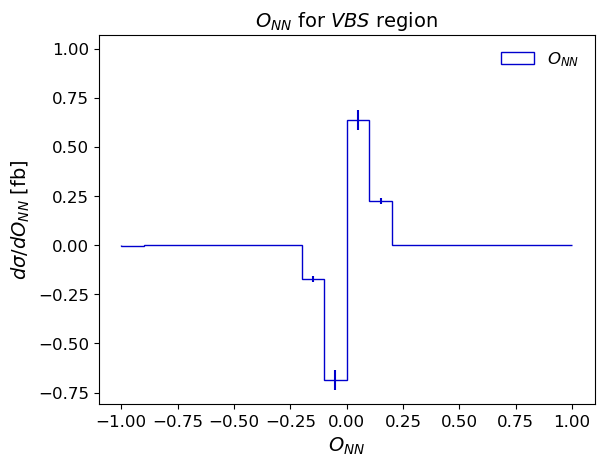

O_NN Fractional Uncertainty: [-3.61474139e-01  0.00000000e+00 -9.96955088e-01  1.51606934e+02
  1.23818911e+02 -3.19561687e+00  1.88433640e+00 -1.73255370e+00
 -8.58395526e-02 -7.63140015e-02  7.78640627e-02  7.35014849e-02
  8.81190461e-01  0.00000000e+00  1.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999972e-01  6.19458935e-01]


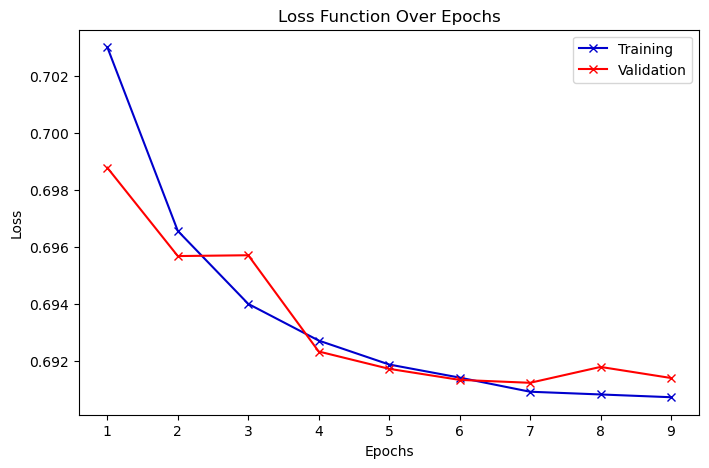

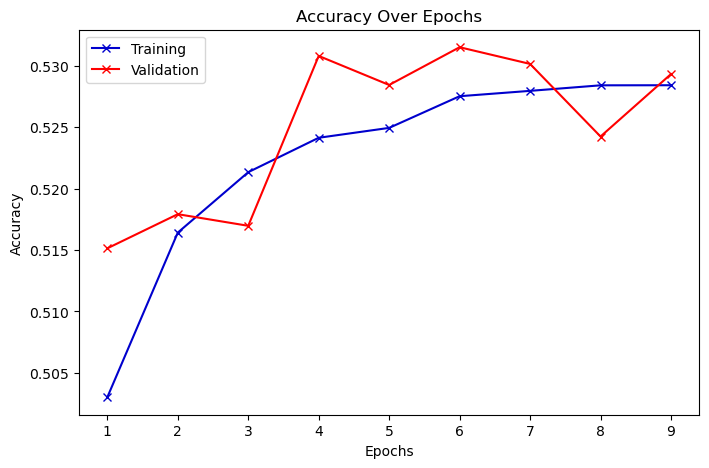

In [ ]:
def __main__():
    vbs_data = DataLoader("VBS_data_cwtil_2.feather", ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi'])
    model_filename = "vbs_l_eta_phi_2.keras"

    param_grid = {
            'learning_rate': [0.001, 0.005, 0.01],
            'neurons': [16, 32, 64, 128],
            'layers': [2, 3, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [256],
            'dropout_rate': [0, 0.1, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        vbs_model = MLModel()
        vbs_model.grid_search(vbs_data.x_data, vbs_data.y_data, param_grid, model_filename)
    
    vbs_model, vbs_history = MLModel.load_ml_model(model_filename)

    vbs_results = vbs_model.predict(vbs_data.x_data)
    Plotter.plot_ml_observable(vbs_results, vbs_data.weight_data, "VBS", 2)
    Plotter.plot_loss(vbs_history)
    Plotter.plot_accuracy(vbs_history)

if __name__ == '__main__':
    __main__()

x_data, y_data, total_weight_data (169076, 24) (169076, 1) (169076, 1)
Loading existing model for vbs_j_eta_phi_2.keras
Model Accuracy: 0.7088 using best hyperparameters {'batch_size': 128, 'dropout_rate': 0.1, 'layers': 4, 'learning_rate': 0.001, 'neurons': 16, 'patience': 2, 'reg_strength': 0.001}
5284/5284 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
ML and Weight shape (169076,) (169076, 1)
chi_squared_1 about y=0: 31673.67008935061


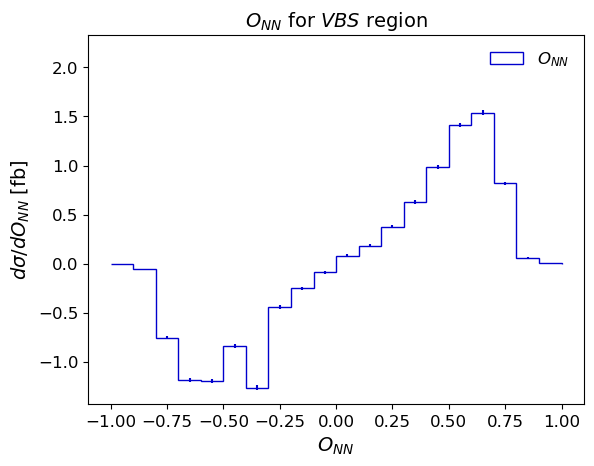

O_NN Fractional Uncertainty: [-0.22360961 -0.06712773 -0.01860172 -0.01626247 -0.01724699 -0.02258137
 -0.02135403 -0.04096044 -0.06510762 -0.17546403  0.19928779  0.08842203
  0.04554575  0.02940729  0.02085353  0.01590048  0.01397794  0.01840644
  0.06340677  0.25467709]


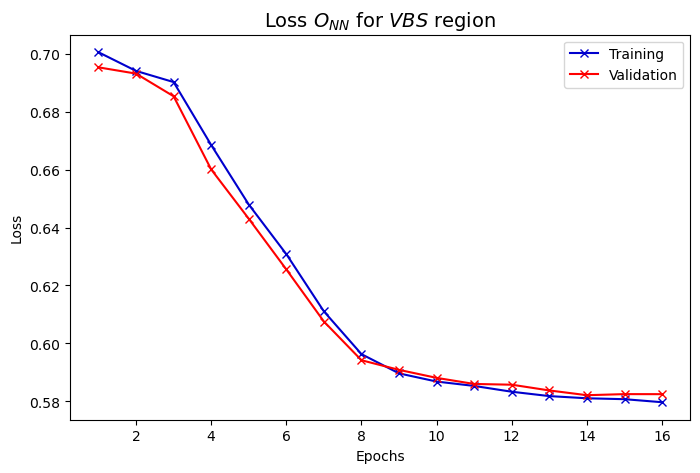

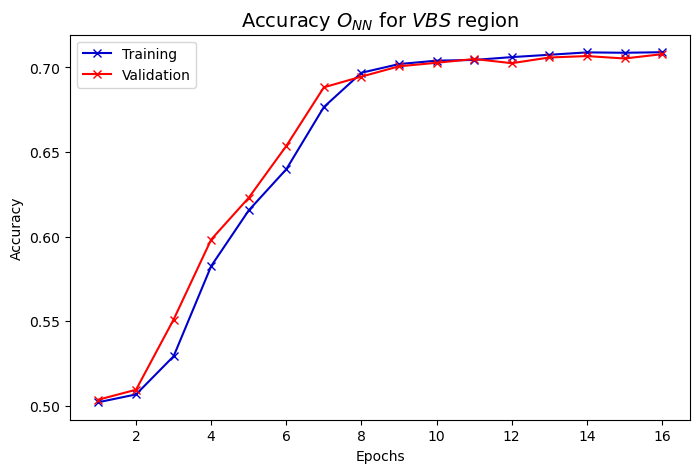

In [ ]:
def __main__():
    vbs_data = DataLoader("VBS_data_cwtil_2.feather", ['Jet.Eta', 'Jet.Phi'])
    model_filename = "vbs_j_eta_phi_2.keras"

    param_grid = {
            'learning_rate': [0.001, 0.005, 0.01],
            'neurons': [16, 32, 64, 128],
            'layers': [2, 3, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.1, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        vbs_model = MLModel()
        vbs_model.grid_search(vbs_data.x_data, vbs_data.y_data, param_grid, model_filename)
    
    vbs_model, vbs_history = MLModel.load_ml_model(model_filename)

    vbs_results = vbs_model.predict(vbs_data.x_data)
    Plotter.plot_ml_observable(vbs_results, vbs_data.weight_data, "VBS", model_filename)
    Plotter.plot_loss(vbs_history, "VBS", model_filename)
    Plotter.plot_accuracy(vbs_history, "VBS", model_filename)

if __name__ == '__main__':
    __main__()

smeft columns [('Electron.Eta', 0), ('Electron.Eta', 1), ('Electron.Eta', 2), ('Electron.Eta', 3), ('Electron.Eta', 4), ('Electron.Eta', 5), ('Electron.Eta', 6), ('Electron.Eta', 7), ('Electron.Eta', 8), ('Electron.Eta', 9), ('Electron.Eta', 10), ('Electron.PT', 0), ('Electron.PT', 1), ('Electron.PT', 2), ('Electron.PT', 3), ('Electron.PT', 4), ('Electron.PT', 5), ('Electron.PT', 6), ('Electron.PT', 7), ('Electron.PT', 8), ('Electron.PT', 9), ('Electron.PT', 10), ('Electron.Phi', 0), ('Electron.Phi', 1), ('Electron.Phi', 2), ('Electron.Phi', 3), ('Electron.Phi', 4), ('Electron.Phi', 5), ('Electron.Phi', 6), ('Electron.Phi', 7), ('Electron.Phi', 8), ('Electron.Phi', 9), ('Electron.Phi', 10), ('Jet.Eta', 0), ('Jet.Eta', 1), ('Jet.Eta', 2), ('Jet.Eta', 3), ('Jet.Eta', 4), ('Jet.Eta', 5), ('Jet.Eta', 6), ('Jet.Eta', 7), ('Jet.Eta', 8), ('Jet.Eta', 9), ('Jet.Eta', 10), ('Jet.PT', 0), ('Jet.PT', 1), ('Jet.PT', 2), ('Jet.PT', 3), ('Jet.PT', 4), ('Jet.PT', 5), ('Jet.PT', 6), ('Jet.PT', 7), ('J

/home/finfullerton/mambaforge/envs/mphys/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.0005, neurons=256, patience=3, reg_strength=0.0005; total time=  24.7s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.0001, neurons=32, patience=3, reg_strength=0; total time=  15.9s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.0005, neurons=256, patience=3, reg_strength=0.0005; total time=  27.7s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.0001, neurons=32, patience=3, reg_strength=0; total time=  23.5s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.0001, neurons=32, patience=3, reg_strength=0.001; total time=  25.6s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.0001, neurons=32, patience=3, reg_strength=0.001; total time=  25.9s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.0001, neurons=32, patience=3, reg_strength=0.0005; total time=  22.9s
[CV] END batch_size=256, dropout_rate=0, layers=2, 

/tmp/ipykernel_602100/3631972959.py:254: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)


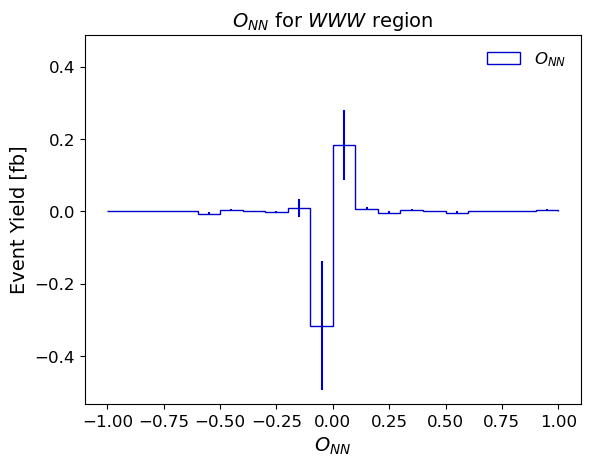

O_NN Fractional Uncertainty: [ 0.          0.          0.          0.         -0.70710812  1.00000001
  0.         -1.49346868  2.73276645 -0.56470474  0.52882964  0.50971994
 -1.          1.          0.         -1.00000001  0.          0.
  0.          1.        ]
ml and Weight shape (18186,) (18186, 1)
chi_squared_1 about y=0: nan


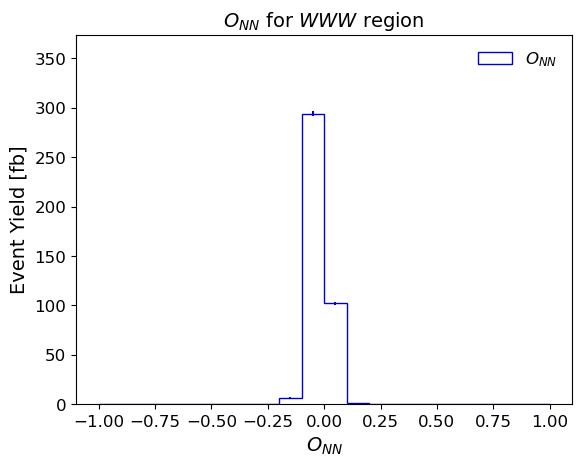

O_NN Fractional Uncertainty: [0.         0.         0.         0.99999999 0.         0.99999998
 0.         0.33334315 0.05918719 0.0089285  0.0151236  0.15420442
 0.         0.99999999 0.         0.         0.         0.
 0.         0.        ]


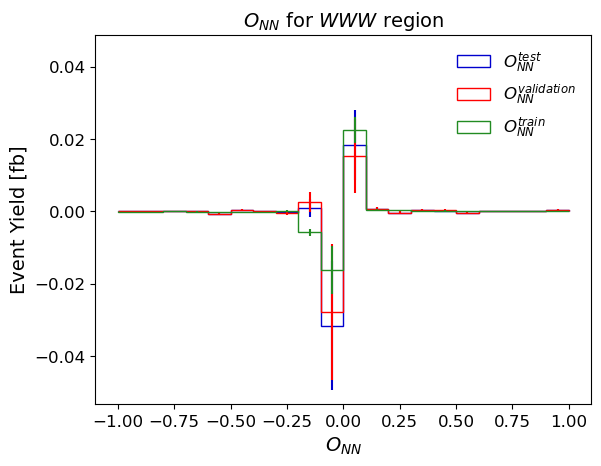

O_NN Fractional Uncertainty: [ 0.          0.          0.          0.         -0.70710812  1.00000001
  0.         -1.49346868  2.73276645 -0.56470474  0.52882964  0.50971994
 -1.          1.          0.         -1.00000001  0.          0.
  0.          1.        ]


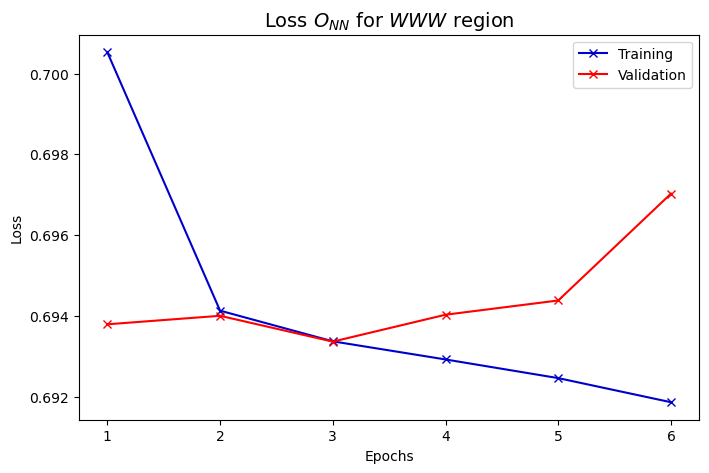

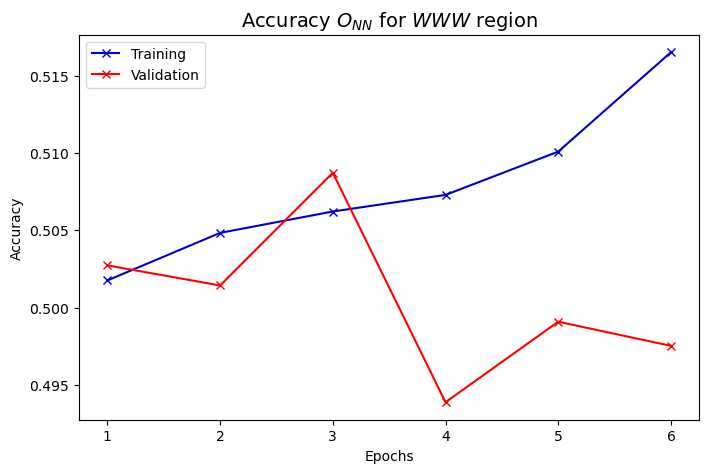

In [6]:
def __main__():
    www_data = DataLoader("analysis_3_data/WWW_data_sm_3.feather", "analysis_3_data/WWW_data_cwtil_large_3.feather", ['Electron.Eta', 'Electron.Phi', 'Electron.PT', 'Muon.Eta', 'Muon.Phi', 'Muon.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.PT', 'MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'], 200, 468)
    model_filename = "2_class_www_lj_miss_eta_phi_pt_3.keras"

    param_grid = {
            'learning_rate': [0.001, 0.0005, 0.0001],
            'neurons': [32, 64, 128, 256],
            'layers': [2, 3, 4, 5, 6],
            'reg_strength': [0, 0.001, 0.0005],
            'patience': [3],
            'batch_size': [256],
            'dropout_rate': [0, 0.05, 0.1, 0.15, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
        meta_data = joblib.load(model_filename.replace(".keras", "_meta_data.joblib"))
        scaler = meta_data["scaler"]
    else:
        print("No existing model found, training new model")
        scaler = sk.preprocessing.StandardScaler()
        www_model = MLModel(scaler, www_data)
        www_model.grid_search(param_grid, model_filename) 

    www_model, www_history = MLModel.load_ml_model(model_filename, scaler, www_data)
    print("smeft test:")
    www_smeft_results = www_model.predict(www_data.smeft_x_test, www_data.smeft_y_test)
    print("sm test:")
    www_sm_results = www_model.predict(www_data.sm_x_data, www_data.sm_y_data)
    print("validation:")
    www_validate_results = www_model.predict(www_data.x_validate, www_data.y_validate)
    print("training:")
    www_train_results = www_model.predict(www_data.x_train, www_data.y_train)

    Plotter.plot_ml_observable(www_smeft_results, www_data.smeft_weights_test, "WWW", model_filename)
    Plotter.plot_ml_observable(www_sm_results, www_data.sm_weights, "WWW", model_filename)
    Plotter.plot_test_validation_ml_observable(www_smeft_results, www_validate_results, www_train_results, www_data.smeft_weights_test, www_data.validate_weights, www_data.train_weights, "WWW", model_filename)
    #Plotter.plot_separate_ml_observable(total_www_results, www_data.total_weights, "WWW", model_filename)
    Plotter.plot_loss(www_history, "WWW", model_filename)
    Plotter.plot_accuracy(www_history, "WWW", model_filename)

if __name__ == '__main__':
    __main__()

x_data, y_data, total_weight_data (69132, 44) (69132, 1) (69132, 1)
No existing model found, training new model
Fitting 2 folds for each of 324 candidates, totalling 648 fits
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=   5.9s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=   6.7s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=   7.6s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  11.2s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=   9.8s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=   9.3s
[CV] END batch_size=128, drop

/home/finfullerton/mambaforge/envs/mphys/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0.001; total time=  10.2s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0; total time=  11.3s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0.0001; total time=  16.9s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0.0001; total time=  18.5s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0; total time=   8.9s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0.001; total time=  14.4s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0.001; total time=  11.5s
[CV] END batch_size=128, dropout_rate=0, layers=3, learn

/tmp/ipykernel_921/1908327891.py:208: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)


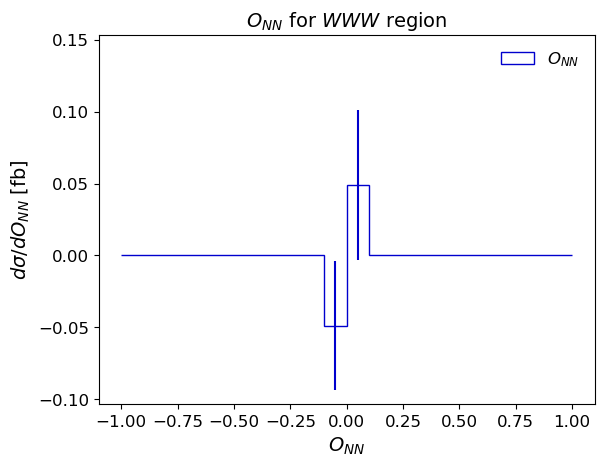

O_NN Fractional Uncertainty: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.92565215  1.06705566  0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


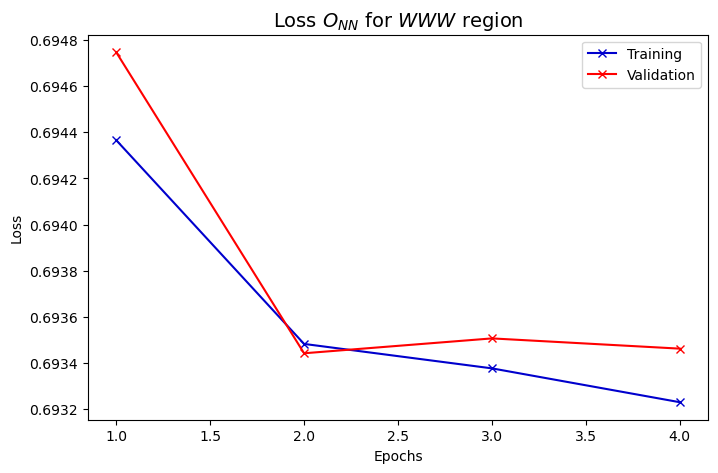

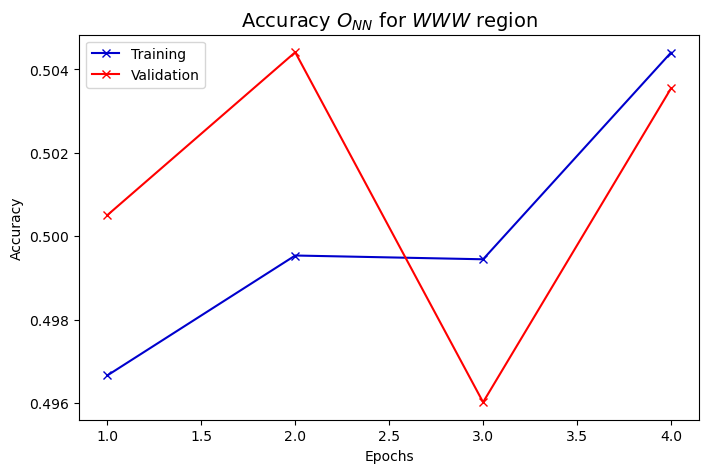

In [ ]:
def __main__():
    www_data = DataLoader("WWW_data_cwtil_large_1.feather", ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi'])
    model_filename = "www_l_eta_phi_2.keras"

    param_grid = {
            'learning_rate': [0.001, 0.005, 0.01],
            'neurons': [16, 32, 64, 128],
            'layers': [2, 3, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.1, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        www_model = MLModel()
        www_model.grid_search(www_data.x_data, www_data.y_data, param_grid, model_filename)
    
    www_model, www_history = MLModel.load_ml_model(model_filename)

    www_results = www_model.predict(www_data.x_data)
    Plotter.plot_ml_observable(www_results, www_data.weight_data, "WWW", model_filename)
    Plotter.plot_loss(www_history, "WWW", model_filename)
    Plotter.plot_accuracy(www_history, "WWW", model_filename)

if __name__ == '__main__':
    __main__()

x_data, y_data, total_weight_data (69132, 22) (69132, 1) (69132, 1)
No existing model found, training new model
Fitting 2 folds for each of 324 candidates, totalling 648 fits
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=   8.4s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=   9.0s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=  11.5s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  12.2s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=   8.6s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  10.8s
[CV] END batch_size=128, drop

/home/finfullerton/mambaforge/envs/mphys/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0.0001; total time=  21.6s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0; total time=   8.4s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0; total time=   9.7s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0.0001; total time=   7.5s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0.001; total time=   8.2s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0.001; total time=   7.5s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=32, patience=2, reg_strength=0; total time=   6.9s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate

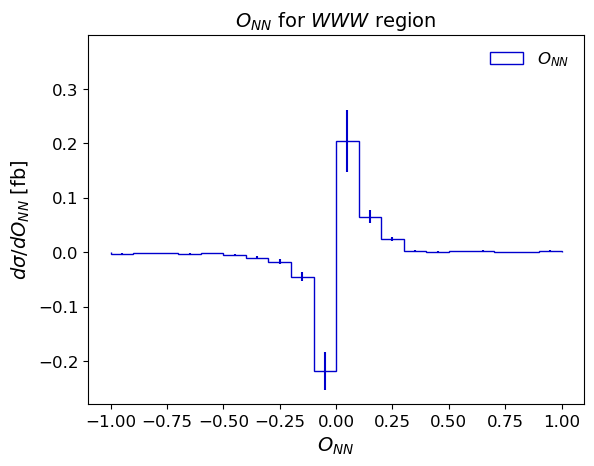

O_NN Fractional Uncertainty: [-0.34252596 -0.47018028 -0.50223995 -0.58848966 -0.50361144 -0.42668882
 -0.27357437 -0.23021262 -0.18072777 -0.16287401  0.27780541  0.18885779
  0.1722075   0.68911024  2.10724115  0.43584532  0.63905653  0.70710701
  0.57735168  0.32412514]


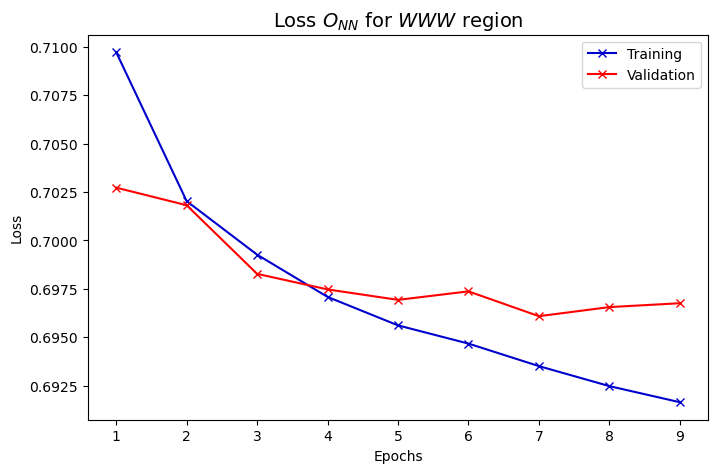

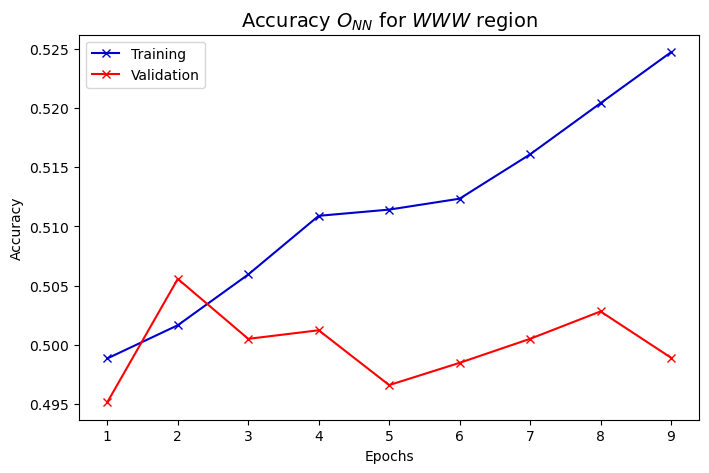

In [ ]:
def __main__():
    www_data = DataLoader("WWW_data_cwtil_large_1.feather", ['Jet.Eta', 'Jet.Phi'])
    model_filename = "www_j_eta_phi_2.keras"

    param_grid = {
            'learning_rate': [0.001, 0.005, 0.01],
            'neurons': [16, 32, 64, 128],
            'layers': [2, 3, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.1, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        www_model = MLModel()
        www_model.grid_search(www_data.x_data, www_data.y_data, param_grid, model_filename)
    
    www_model, www_history = MLModel.load_ml_model(model_filename)

    www_results = www_model.predict(www_data.x_data)
    Plotter.plot_ml_observable(www_results, www_data.weight_data, "WWW", model_filename)
    Plotter.plot_loss(www_history, "WWW", model_filename)
    Plotter.plot_accuracy(www_history, "WWW", model_filename)

if __name__ == '__main__':
    __main__()